In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import string
import time
from tqdm import tqdm
from collections import defaultdict

from pathlib import Path

In [18]:
names = {
    "Log. Reg": "#999999", 
    "Lin. SVM":"#f781bf", 
    "SVM":"#a65628", 
    "kNN": "#ffff33", 
    "RF":"#ff7f00", 
    "MLP":"#984ea3",
    "XGB":"#cc99ff",
    "SPORF":"#4daf4a",
    "MORF":"#e41a1c",
    "ConvNet":"#377eb8"
}

tags = ['morf-3_cnn-3', ""]

paths = {
    "Circle Segments":
        lambda tag: f"circle_experiment/circle_results_{tag}.csv",
    "Orthogonal Bars":
        lambda tag: f"hvbar/hvbar_results_{tag}.csv",
    "Noisy Impulse":
        lambda tag: f"timeseries_1d/impulse_results_{tag}.csv",
}

test_paths = {
    "Circle Segments":[
        f"circle_experiment/circle_results{tag}_test_time.csv",
    ],
    "Orthogonal Bars":[
        f"hvbar/hvbar_results{tag}_test_time.csv",
    ],
    "Noisy Impulse":[
        f"timeseries_1d/impulse_results{tag}_test_time.csv",
    ],
}

mnist_paths = {
    "mnist":[
        f"mnist/mnist_results{tag}_sklearn.csv",
        f"mnist/mnist_results{tag}_CNN.csv",
    ]
}

In [27]:
def plot_simulation(ax, name, paths, cnn_path=None, yvar='Lhat', ylog=False, simulations=True, tags=None):
    ## Algos
    d1 = pd.DataFrame(columns = ['classifier', 'n', yvar, 'color'])
    k = 0
    used_clfs = defaultdict(list)
    if tags is not None:
        paths = [paths(tag) for tag in tags]
    elif not isinstance(paths, list):
        paths = [paths]
    for i,path in enumerate(paths):
        dat = pd.read_csv(path)
        for ni in np.unique(dat['n']):
            for cl in np.unique(dat['classifier']):
                tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][yvar]
                tmp = np.mean(tmp)
                if cl == 'RerF':
                    cl = 'SPORF'
                elif cl == 'S-RerF':
                    cl = 'MF'
                elif cl == 'CNN':
                    cl = 'ConvNet'
                if cl in used_clfs[ni]:
                    d1.loc[k] = [cl + f' (unif)'] + [ni] + [tmp] + [names[cl] + f' (unif)']
                else:
                    used_clfs[ni].append(cl)
                    d1.loc[k] = [cl] + [ni] + [tmp] + [names[cl]]
                k += 1
    ## Plot All
    for key in names.keys():
        grp = d1[d1['classifier'] == key]
        if len(grp) == 0:
            continue
        ax = grp.plot(ax=ax, kind='line', x='n', y=yvar, label=key, \
                c = names[key], alpha=1)
        ax.set_xscale('log')
        if yvar == 'Lhat':
            if simulations:
                ax.set_ylim([0,0.55])
                ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5])
            else:
                ax.set_ylim([
                    0, d1[yvar].max()
                ])
                ax.set_yticks(np.arange(
                    0, d1[yvar].max(), 0.1
                ))
        if simulations:
            ax.set_xticks([10,100,1000])
        else:
            ax.set_xticks(
                [10**k for k in np.arange(
                    int(np.log10(d1['n'].min())),
                    int(np.log10(d1['n'].max()))+1
                )]
            )
    #ax.title.set_text('%s Classification' % name)
    #ax.legend(loc='best',title='Algorithm', borderpad=0.1, labelspacing=0.5, bbox_to_anchor=(1, 0.5))
    ax.get_legend().remove()
    ax.set_xlabel('')
    #ax.text(-0.1, 1.1, "%s" % string.ascii_uppercase[n], transform=ax.transAxes, size=15, weight='bold')
    if ylog:
        ax.set_yscale('log')

In [28]:
fontsize = 9
legendsize = 7.5
sns.set(); sns.set(style="darkgrid", rc={'font.size':fontsize,
                                         'figure.titlesize':fontsize,
                                         'legend.fontsize': fontsize,
                                         'xtick.labelsize': fontsize,
                                         'ytick.labelsize': fontsize,
                                         'axes.labelsize': fontsize,
                                         'axes.titlesize':fontsize})
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

<Figure size 432x288 with 0 Axes>

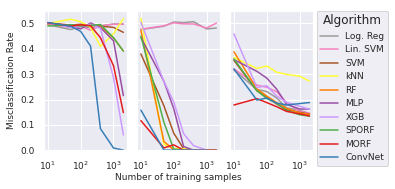

In [29]:
legend = True
plt.clf()
#fig, axes = plt.subplots(1,3, figsize = (7.1,1.5), sharey=True, sharex=False)
if legend:
    fig, axes = plt.subplots(1,3, figsize = (6,3), sharey=True, sharex=False)
else:
    fig, axes = plt.subplots(1,3, figsize = (4,3), sharey=True, sharex=False)


for ax,(name,path),i in zip(axes, paths.items(),range(len(axes))):
    plot_simulation(ax,name,path,tags=tags,yvar='Lhat')


handles, labels = axes[1].get_legend_handles_labels()
if legend == True:
    lgd = axes[2].legend(handles, labels, title='Algorithm', loc='upper left' ,bbox_to_anchor = (1.04,1), borderaxespad=0)#, prop={'size': 7.5})#bbox_to_anchor = (0.55,-0.15,1,1), borderaxespad=0)
    bbox = (lgd,)
else:
    bbox=()

bax = fig.add_subplot(111, frameon=False)

bax.grid(None)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.ylabel('Misclassification Rate') #Mean Loss
plt.xlabel('Number of training samples')
plt.tight_layout()
fig.subplots_adjust(wspace=0.12)
#plt.savefig(f'./figures/s-rerf_3plot_experiment{tag}.pdf',dpi=300,format='pdf')
#bbox = matplotlib.transforms.Bbox([[0,0, [6.5, 3]])

#fig.savefig('./figures/3plot_experiment.pdf',bbox_inches='tight',bbox_extra_artists=bbox,format='pdf')

plt.show()

## Time Plots

<Figure size 432x288 with 0 Axes>

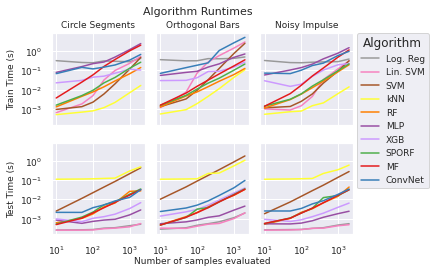

In [208]:
plt.clf()
fig, axes = plt.subplots(2,3, figsize = (5.4,3.7), sharey=True, sharex=True)
ylog=True

for ax,(name,path) in zip(axes[0], paths.items()):
    plot_simulation(ax,name,path,yvar='trainTime',ylog=ylog)
    ax.set_title(name)
    #ax.set_ylim((0,50))
    
for ax,(name,path) in zip(axes[1], test_paths.items()):
    plot_simulation(ax,name,path,yvar='testTime',ylog=ylog)
    #ax.set_ylim((0,50))

ttl = fig.suptitle('Algorithm Runtimes',fontsize=fontsize+2)

#plt.setp(axes, xticks=axes[0,0].get_xticks()+0.1)

handles, labels = axes[1][1].get_legend_handles_labels()
lgd = axes[0][2].legend(handles, labels, title='Algorithm', loc='upper left' ,bbox_to_anchor = (1.04,1), borderaxespad=0)#bbox_to_anchor = (0.55,-0.15,1,1), borderaxespad=0)

bax = fig.add_subplot(111, frameon=False)

bax.grid(None)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)


axes[0][0].set_ylabel('Train Time (s)')
axes[1][0].set_ylabel('Test Time (s)')
#plt.ylabel('trainTime') #Mean Loss
plt.xlabel('Number of samples evaluated')
#plt.title('Algorithm Runtimes')
#plt.tight_layout()
fig.subplots_adjust(wspace=0.12)
#bbox = matplotlib.transforms.Bbox([[0,0, [6.5, 3]])
fig.savefig(f'./figures/s-rerf_6plot_times{tag}.pdf',bbox_inches='tight', bbox_extra_artists=(lgd,ttl,),format='pdf')

plt.show()

<Figure size 432x288 with 0 Axes>

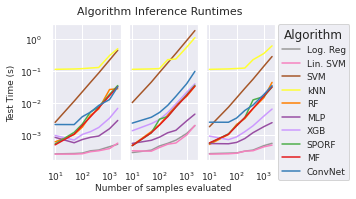

In [218]:
plt.clf()
fig, axes = plt.subplots(1,3, figsize = (4,2.5), sharey=True, sharex=True)
ylog=True
    
for ax,(name,path) in zip(axes, test_paths.items()):
    plot_simulation(ax,name,path,yvar='testTime',ylog=ylog)
    #ax.set_ylim((0,50))

ttl = fig.suptitle('Algorithm Inference Runtimes',fontsize=fontsize+2)

#plt.setp(axes, xticks=axes[0,0].get_xticks()+0.1)

handles, labels = axes[1].get_legend_handles_labels()
lgd = axes[2].legend(handles, labels, title='Algorithm', loc='upper left' ,bbox_to_anchor = (1.04,1), borderaxespad=0)#bbox_to_anchor = (0.55,-0.15,1,1), borderaxespad=0)

bax = fig.add_subplot(111, frameon=False)

bax.grid(None)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)


axes[0].set_ylabel('Test Time (s)')
#plt.ylabel('trainTime') #Mean Loss
plt.xlabel('Number of samples evaluated')
#plt.title('Algorithm Runtimes')
#plt.tight_layout()
fig.subplots_adjust(wspace=0.12)
#bbox = matplotlib.transforms.Bbox([[0,0, [6.5, 3]])
#fig.savefig(f'./figures/s-rerf_6plot_inference_times{tag}.pdf',bbox_inches='tight', bbox_extra_artists=(lgd,ttl,),format='pdf')

plt.show()

## MNIST

<Figure size 432x288 with 0 Axes>

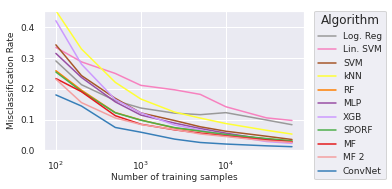

In [41]:
legend = True
plt.clf()
fig, ax = plt.subplots(1,1, figsize = (6, 3), sharey=False, sharex=False)

for name,paths in mnist_paths.items():
    plot_simulation(ax,name,paths,yvar='Lhat',simulations=False)


handles, labels = ax.get_legend_handles_labels()
if legend == True:
    lgd = ax.legend(handles, labels, title='Algorithm', loc='upper left' ,bbox_to_anchor = (1.04,1), borderaxespad=0)#, prop={'size': 7.5})#bbox_to_anchor = (0.55,-0.15,1,1), borderaxespad=0)
    bbox = (lgd,)
else:
    bbox=()

bax = fig.add_subplot(111, frameon=False)

bax.grid(None)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.legend(title='Algorithm', loc='upper left' ,bbox_to_anchor = (1.04,1), borderaxespad=0)
plt.ylabel('Misclassification Rate') #Mean Loss
plt.xlabel('Number of training samples')
plt.tight_layout()
fig.subplots_adjust(wspace=0.12)
#plt.savefig(f'./figures/s-rerf_mnist_experiment{tag}.pdf',dpi=300,format='pdf')
#bbox = matplotlib.transforms.Bbox([[0,0, [6.5, 3]])

#fig.savefig('./figures/3plot_experiment.pdf',bbox_inches='tight',bbox_extra_artists=bbox,format='pdf')

plt.show()

## Forest Stats

In [211]:
experiment_dirs = {
    "Circle Segments": f"circle_experiment",
    "Orthogonal Bars": f"hvbar/",
    "Noisy Impulse": f"timeseries_1d/",
}
methods = ['RF', 'SPORF', 'MF']
file_base = 'forest_stats_'

data_keys = [
    'starting tree',
    "max depth",
    "avg leaf node depth",
    "num leaf nodes",
]
sample_sizes = [10,50,100,200,400,1000,2000]
n_runs = 5

In [234]:
stats = ['Max height', 'Mean depth', '# Leaves']
stat_df = pd.DataFrame(columns =
    ['experiment', 'classifier', 'n', 'run'] + stats
)
k = 0

for experiment,directory in experiment_dirs.items():
    for method in methods:
        path = Path(experiment_dirs[experiment]) / f"{file_base}{method}.log"

        with open(path, 'r') as f:
            dat = f.readlines()
        assert len(dat) % n_runs == 0

        for i in range(int(len(dat)/len(data_keys))):
            n = sample_sizes[int(i / n_runs)]
            run = i % n_runs
            fields = []
            for j,key in enumerate(data_keys[1:]):
                line = dat[i*len(data_keys)+j+1].strip().split()
                assert line[0] == data_keys[1+j].split(" ")[0] #sanity check
                fields.append(float(line[-1]))
            stat_df.loc[k] = [experiment, method, n, run] + fields
            k += 1

/home/rflperry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/rflperry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/rflperry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/rflperry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/rflperry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/rflperry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/rflperry/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: U

<Figure size 432x288 with 0 Axes>

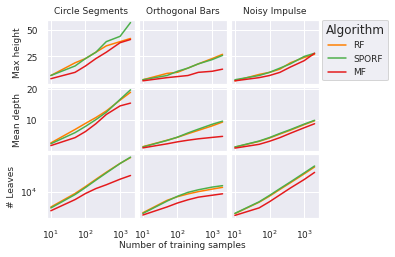

In [237]:
legend = True
plt.clf()
fig, axes = plt.subplots(3,3, figsize = (6,4), sharex='col', sharey='row')

for r,yvar in enumerate(stats):
    for c,experiment in enumerate(experiment_dirs.keys()):
        for method in methods:
            grp = stat_df[stat_df['experiment']==experiment][stat_df['classifier']==method].groupby(
                ['experiment', 'classifier', 'n'], as_index=False
            ).agg(
                {yvar:'mean'}
            )
            ax = grp.plot(ax=axes[r,c], kind='line', x='n', y=yvar, label=method, \
                    c = names[method], alpha=1)
            ax.set_xscale('log')
            ax.get_legend().remove()
            ax.set_xlabel('')
            if r == 0:
                ax.set_title(experiment)
                ax.set_yticks([25,50])
            if r == 2:
                ax.set_yscale('log')
                ax.set_xticks([10,100,1000])
    axes[r,0].set_ylabel(yvar)

handles, labels = axes[0][0].get_legend_handles_labels()
if legend == True:
    lgd = axes[0][2].legend(handles, labels, title='Algorithm', loc='upper left' ,bbox_to_anchor = (1.04,1), borderaxespad=0)#, prop={'size': 7.5})#bbox_to_anchor = (0.55,-0.15,1,1), borderaxespad=0)
    bbox = (lgd,)
else:
    bbox=()

bax = fig.add_subplot(111, frameon=False)

bax.grid(None)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel('Number of training samples')
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(hspace=0.05)
#plt.savefig(f'./figures/complexity_6plot_experiment{tag}.pdf',dpi=300,format='pdf')
#bbox = matplotlib.transforms.Bbox([[0,0, [6.5, 3]])
plt.show()

In [12]:
with open('/home/rflperry/morf_neurips_experiments/circle_experiment/optimization_results_100/MF_04-22-14:00_best_params.pkl', 'rb') as f:
    d = pickle.load(f)

In [13]:
d

{'name': 'MF',
 'params': {'max_features': 0.1,
  'patch_height_max': 1,
  'patch_height_min': 1,
  'patch_width_max': 9,
  'patch_width_min': 1},
 'score': 0.5701128936423054}